Import Libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

Import and read the data

In [3]:
EOSINOPHIL_dir = [r'dataset2-master/images\TRAIN\EOSINOPHIL']
LYMPHOCYTE_dir = [r'dataset2-master/images\TRAIN\LYMPHOCYTE']
MONOCYTE_dir = [r'dataset2-master/images\TRAIN\MONOCYTE']
NEUTROPHIL_dir = [r'dataset2-master/images\TRAIN\NEUTROPHIL']

import os

filepaths = []
labels = []
dict_list = [EOSINOPHIL_dir, LYMPHOCYTE_dir, MONOCYTE_dir, NEUTROPHIL_dir]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


for i, dir_list in enumerate(dict_list):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

total = len(labels)
print(f"\nTotal files: {total}")

                                           filepaths      labels
0  dataset2-master/images\TRAIN\EOSINOPHIL\_0_116...  EOSINOPHIL
1  dataset2-master/images\TRAIN\EOSINOPHIL\_0_141...  EOSINOPHIL
2  dataset2-master/images\TRAIN\EOSINOPHIL\_0_207...  EOSINOPHIL
3  dataset2-master/images\TRAIN\EOSINOPHIL\_0_214...  EOSINOPHIL
4  dataset2-master/images\TRAIN\EOSINOPHIL\_0_237...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64

Total files: 9957


In [3]:
bloodCell_df.shape

(9957, 2)

In [4]:
EOSINOPHIL_dirtest = [r'dataset2-master/images\TEST\EOSINOPHIL']
LYMPHOCYTE_dirtest = [r'dataset2-master/images\TEST\LYMPHOCYTE']
MONOCYTE_dirtest = [r'dataset2-master/images\TEST\MONOCYTE']
NEUTROPHIL_dirtest = [r'dataset2-master/images\TEST\NEUTROPHIL']

filepathstest = [] 
labelstest = []
dict_listtest = [EOSINOPHIL_dirtest, LYMPHOCYTE_dirtest, MONOCYTE_dirtest, NEUTROPHIL_dirtest]
class_labelstest = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


for i, dir_list in enumerate(dict_listtest):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepathstest.append(fpath)
            labelstest.append(class_labels[i])

Fseriestest = pd.Series(filepathstest, name="filepaths")
Lseriestest = pd.Series(labelstest, name="labels")
bloodCell_datatest = pd.concat([Fseriestest, Lseriestest], axis=1)
bloodCell_dftest = pd.DataFrame(bloodCell_datatest)
print(bloodCell_dftest.head())
print(bloodCell_dftest["labels"].value_counts())

totaltest = len(labelstest)
print(f"\nTotal files: {totaltest}")

                                           filepaths      labels
0  dataset2-master/images\TEST\EOSINOPHIL\_0_1616...  EOSINOPHIL
1  dataset2-master/images\TEST\EOSINOPHIL\_0_1794...  EOSINOPHIL
2  dataset2-master/images\TEST\EOSINOPHIL\_0_1845...  EOSINOPHIL
3  dataset2-master/images\TEST\EOSINOPHIL\_0_187....  EOSINOPHIL
4  dataset2-master/images\TEST\EOSINOPHIL\_0_196....  EOSINOPHIL
labels
NEUTROPHIL    624
EOSINOPHIL    623
LYMPHOCYTE    620
MONOCYTE      620
Name: count, dtype: int64

Total files: 2487


# Preprocessing

In [5]:
train_images = bloodCell_df
test_images = bloodCell_dftest

train_set = train_images
val_set = test_images

# randomize the data
train_set = train_set.sample(frac=1).reset_index(drop=True)
val_set = val_set.sample(frac=1).reset_index(drop=True)

print(train_set.shape)
print(test_images.shape)

(9957, 2)
(2487, 2)


# Import pretrained model (we use mobilenetv2)

In [6]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 9957 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


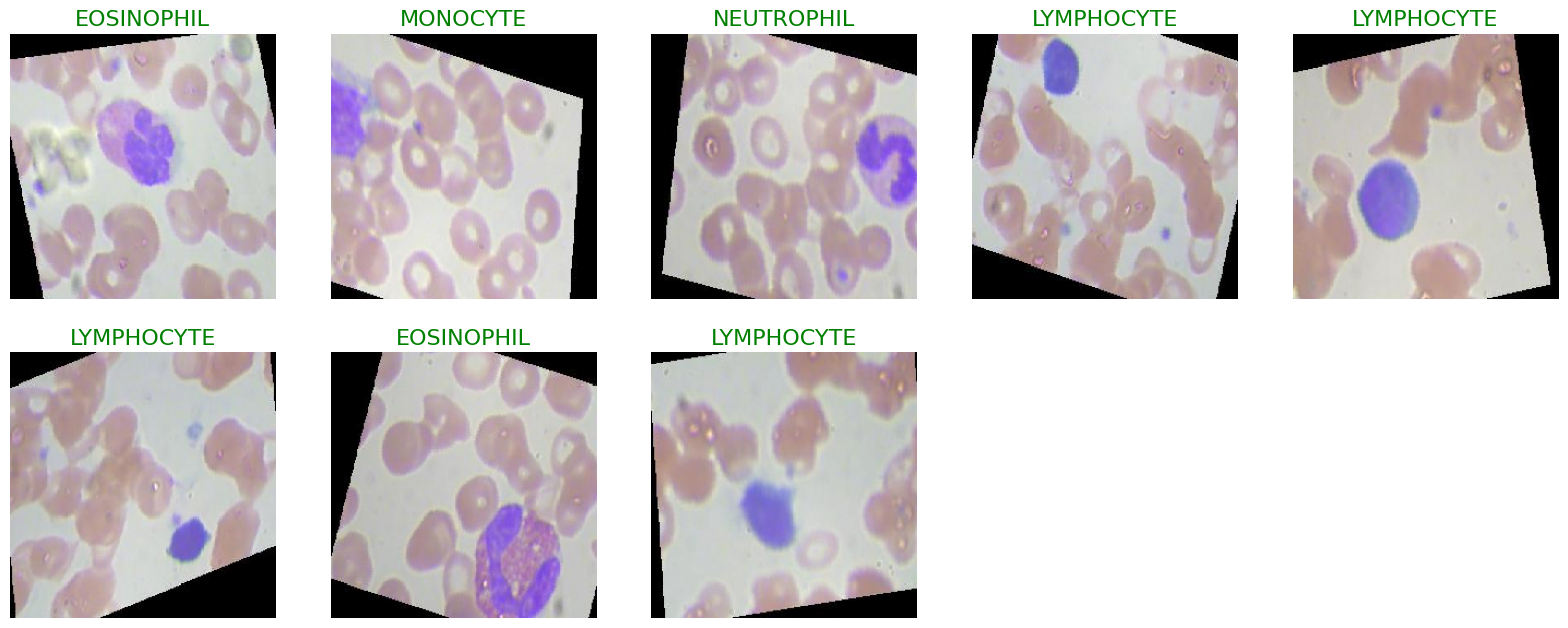

In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

# Create the Model

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [11]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
1245/1245 [==============================] - 65s 52ms/step - loss: 1.1831 - accuracy: 0.4883 - val_loss: 0.9737 - val_accuracy: 0.5255
Epoch 2/10
1245/1245 [==============================] - 62s 50ms/step - loss: 0.7160 - accuracy: 0.6927 - val_loss: 0.6103 - val_accuracy: 0.7145
Epoch 3/10
1245/1245 [==============================] - 62s 50ms/step - loss: 0.4520 - accuracy: 0.8136 - val_loss: 0.7012 - val_accuracy: 0.7061
Epoch 4/10
1245/1245 [==============================] - 62s 50ms/step - loss: 0.3183 - accuracy: 0.8738 - val_loss: 0.6904 - val_accuracy: 0.7624
Epoch 5/10
1245/1245 [==============================] - 62s 50ms/step - loss: 0.2314 - accuracy: 0.9059 - val_loss: 0.4976 - val_accuracy: 0.7801
Epoch 6/10
1023/1245 [=======================>......] - ETA: 10s - loss: 0.1637 - accuracy: 0.9369

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("Blood_Cell.h5")


In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()